# Fluxo de veículos nos ponto de radares estáticos em Teresina

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import calendar
import glob

from geobr import read_municipality

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Em uma das minhas atribuições no setor de trânsito, fui encarregado de monitorar o funcionamento dos radares em Teresina. Em colaboração com a equipe de TI do órgão, desenvolvemos um mecanismo para coletar os dados.

A tarefa envolveu o acompanhamento do fluxo de veículos em cada ponto de radar, identificando períodos de pelo menos 24 horas sem captação, o que poderia indicar alguma irregularidade no equipamento. Agregamos diversos arquivos e procedemos à extração dos dados. Os dados a seguir são referentes ao mês de maio de 2023 e não expõem nenhuma dado privado

In [18]:
def join_file():
    # file of the numeration of equipaments and Current location
    id_radar = pd.read_excel('Codigos e endereços - RADARES.xls')
    id_radar[['Latitude', 'Longitude']] = id_radar['coordenadas'].str.split(', ', n=1, expand=True)

    folder_path = 'D:/OneDrive/DEV/fluxo_cars/files'

    # Pattern to match CSV files (e.g., '*.csv' for all CSV files)
    file_pattern = '*05-2023.csv'

    # Get a list of file paths matching the pattern
    file_paths = glob.glob(folder_path + '/' + file_pattern)

    # Initialize an empty list to store the DataFrames
    dfs = []

    # Read each CSV file and append its DataFrame to the list
    for file_path in file_paths:
        df = pd.read_csv(file_path)
        # df = df[df['PlacaVeiculo'] != 0]
        dfs.append(df)

    # Concatenate all DataFrames into a single DataFrame
    combined_df = pd.concat(dfs)

    # filter column for rows with placas
    combined_df = combined_df[combined_df['PlacaVeiculo'] != '0']
    combined_df['DataHoraPassagem'] = combined_df['DataHoraPassagem'].str[:19]
    combined_df['DataHoraPassagem'] = pd.to_datetime(combined_df['DataHoraPassagem'])
    combined_df = pd.merge(combined_df, id_radar, left_on='Equipamento', right_on='COD EQUIP')
    combined_df = combined_df[['Id', 'DataHoraPassagem','PlacaVeiculo',  'COD EQUIP', 'ENDEREÇO', 'Latitude', 'Longitude']]
    combined_df['dia'] = combined_df['DataHoraPassagem'].dt.day
    combined_df['hora'] = combined_df['DataHoraPassagem'].dt.hour
    combined_df['Equipamento'] = combined_df['COD EQUIP'] + ' - ' + combined_df['ENDEREÇO']
    return combined_df

In [19]:
combined_df =  join_file()
combined_df.shape

(11259754, 10)

# Algumas Informações descritivas

Os dois gráficos a seguir oferecem informações descritivas dos dados. O primeiro mostra a contagem de registros, revelando que terças-feiras são os dias mais movimentados.

O segundo gráfico ilustra o fluxo de veículos por hora do dia. As informações destacam dois horários de pico: às 7h e às 17h

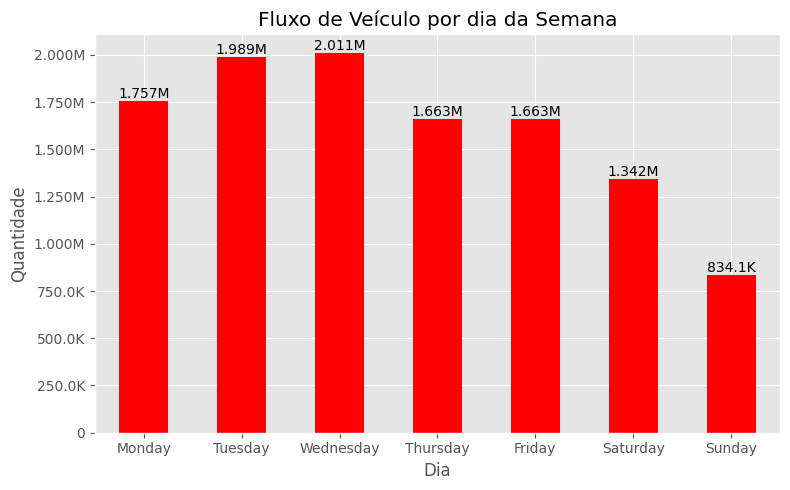

In [20]:
def flux_dayweek():
    combined_df['DataHoraPassagem'] = pd.to_datetime(combined_df['DataHoraPassagem'])
    combined_df['day'] = combined_df['DataHoraPassagem'].dt.day_name()


    day_counts = combined_df['day'].value_counts().sort_index()

    week_order = list(calendar.day_name)

    # Create a Categorical data type with the desired order
    day_counts.index = pd.Categorical(day_counts.index, categories=week_order, ordered=True)

    # Sort the index based on the custom order
    day_counts = day_counts.sort_index()

    # Create the bar plot
    plt.figure(figsize=(8, 5))
    ax = day_counts.plot(kind='bar', color = 'red')
    plt.xlabel('Dia')
    plt.ylabel('Quantidade')
    plt.title('Fluxo de Veículo por dia da Semana')
    plt.xticks(rotation=0)  # Rotate x-axis labels for better visibility


    # Add the values above each bar with dots for thousands separator
    def format_large_numbers(x, pos):
        if x >= 1e6:
            return '{:.3f}M'.format(x * 1e-6)
        elif x >= 1e3:
            return '{:.1f}K'.format(x * 1e-3)
        else:
            return str(int(x))

    ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_large_numbers))

    # Add the values above each bar
    for i, count in enumerate(day_counts):
        ax.annotate(format_large_numbers(count, 0), xy=(i, count), ha='center', va='bottom')
    plt.tight_layout()
    plt.style.use('ggplot')
    plt.show()

flux_dayweek()

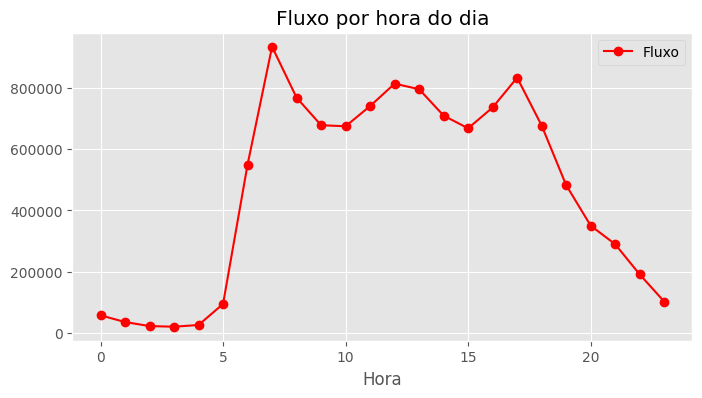

In [21]:
def flux_hour():

    flux_hora = combined_df['hora'].value_counts().to_frame("Quantidade")
    flux_hora = flux_hora.sort_values(by='hora', ascending=True)
    x = flux_hora.index
    y = flux_hora['Quantidade']


    plt.figure(figsize=(8, 4))
    plt.plot(x, y, label='Fluxo', marker='o', color='red')


    # Add labels and title
    plt.xlabel('Hora')
    plt.title('Fluxo por hora do dia')

    # Add a legend to differentiate the lines
    plt.legend()

    # Show the plot
    plt.grid(True)
    plt.show()

flux_hour()

Outra informação pertinente é a quantidade de placas, ou seja, veículos distintos que foram registrados pelos radares. Existem algumas falhas, aonde o registro não foi feito da forma correta,dificultando a identificação do número exato, Entrentanto, temos o total de 1.338.437 placas diferentes.

In [25]:
combined_df['PlacaVeiculo'].value_counts().count()

1338437

# HeatMap para todos os pontos reunidos

Neste primeiro heatmap, optamos por não fazer distinção de localidade. Ele pode ser utilizado como um parâmetro para compreender o fluxo de veículos em toda a cidade, sendo posível obter dados sobre os horários de pico, os dias mais movimentados e o impacto dos finais de semana na redução do tráfego nas vias, entre outras informações 

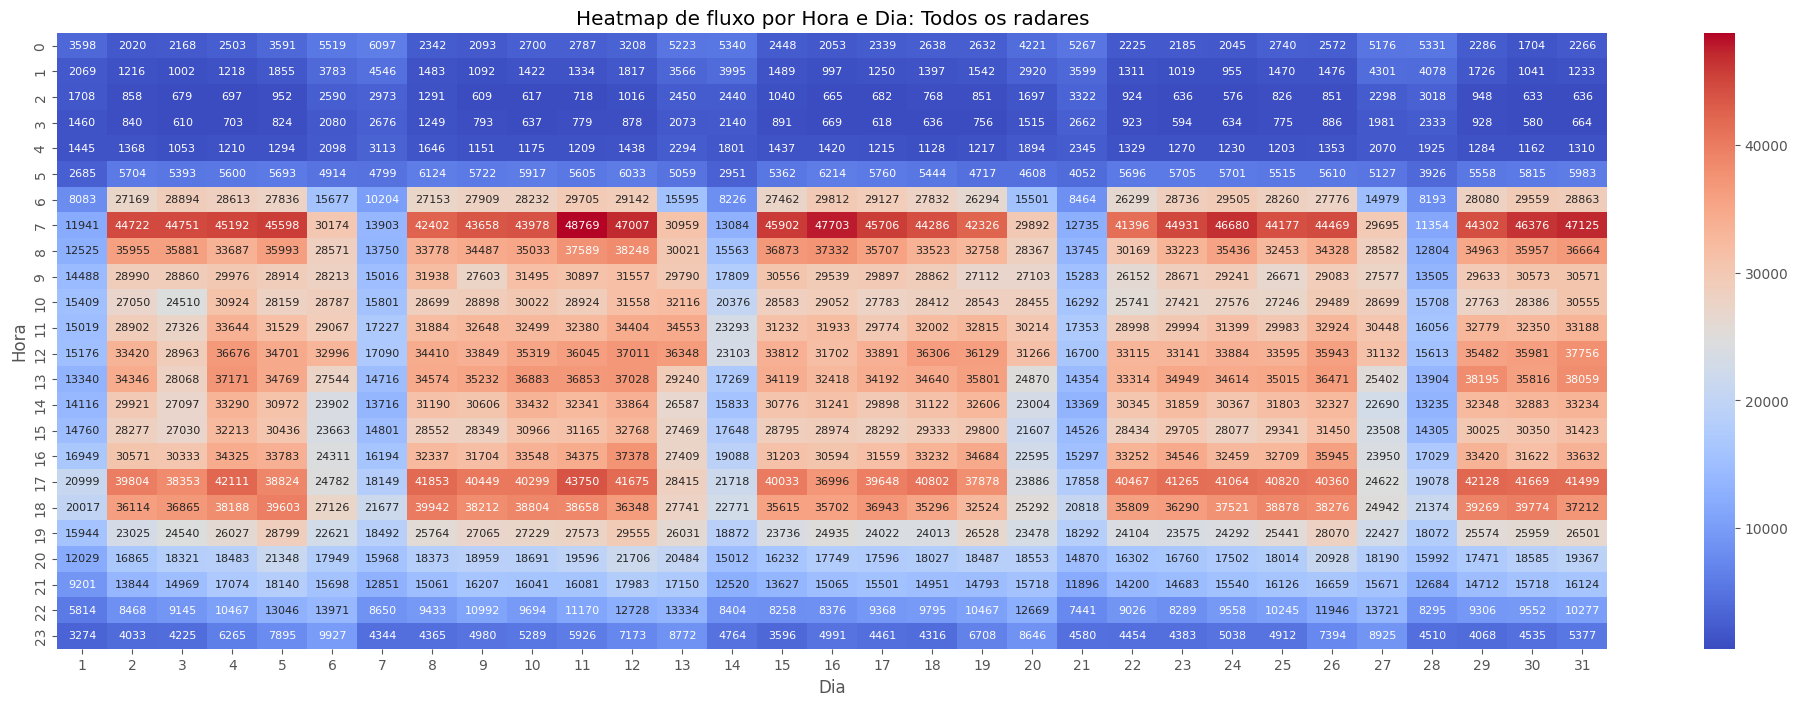

In [15]:
def heatmap_all():
    teste = combined_df.groupby(['dia', 'hora']).size().reset_index(name='count')
    teste['count'] = teste['count'].astype(int)
    teste = teste.pivot_table(index=('hora'), columns= str('dia'), values='count', aggfunc='sum')
    plt.figure(figsize=(25,8))
    sns.heatmap(teste,  cmap="coolwarm", annot=True, fmt=".0f", annot_kws={'size': 8})
    plt.xlabel('Dia')
    plt.ylabel('Hora')
    plt.title('Heatmap de fluxo por Hora e Dia: Todos os radares')
    plt.show()

heatmap_all()

# Heatmap para cada ponto de radar em Teresina - pi

In [16]:
def heatmap_equip(equip_name):
    # Filter the combined_df based on the desired equip
    filtered_df = combined_df[combined_df['Equipamento'] == equip_name]

    # Group by 'dia' and 'hora' and calculate the count
    teste = filtered_df.groupby(['dia', 'hora']).size().reset_index(name='count')

    teste['count'] = teste['count'].astype(int)

    # Pivot the table for heatmap visualization
    teste = teste.pivot_table(index='hora', columns='dia', values='count', aggfunc='sum')
    
    array = teste.values.T
    arr = np.ravel(array)
    nan_indices = np.where(np.isnan(arr))[0]

    sequence_start = None
    sequence_end = None

    for i in range(len(nan_indices) - 23):
        if np.all(nan_indices[i:i+24] == np.arange(nan_indices[i], nan_indices[i]+24)):
            sequence_start = nan_indices[i]
            sequence_end = nan_indices[i+23]
            break

    # Count the number of NaN values and the number of values in sequence
    num_nan = teste.isnull().sum().sum()

    # Create the heatmap
    plt.figure(figsize=(30, 10))
    sns.heatmap(teste, cmap="coolwarm", annot=True, fmt=".0f")
    plt.xlabel('Dia')
    plt.ylabel('Hora')
    plt.title(f"Heatmap de fluxo por Hora e Dia: {equip_name}")
    plt.show()

    # Print the count of NaN values and values in sequence
    print("Number of NaN values:", num_nan)
    if sequence_start is not None and sequence_end is not None:
        print("Start Index:", sequence_start)
        print("End Index:", sequence_end)
    else:
        print("No sequence of 24 NaN values found.")


# Heatmap de cada radar em Teresina

Essa etapa do serviço foi a mais "trabalhosa". Foi necessário criar um loop para obtermos os dados de cada radar, com o objetivo de identificar qualquer período de inatividade superior a 24 horas. Os dados foram extraídos mês a mês, e o título em cada imagem identifica a localização do aparelho. A última informação impressa diz respeito à ocorrência de inoperância.

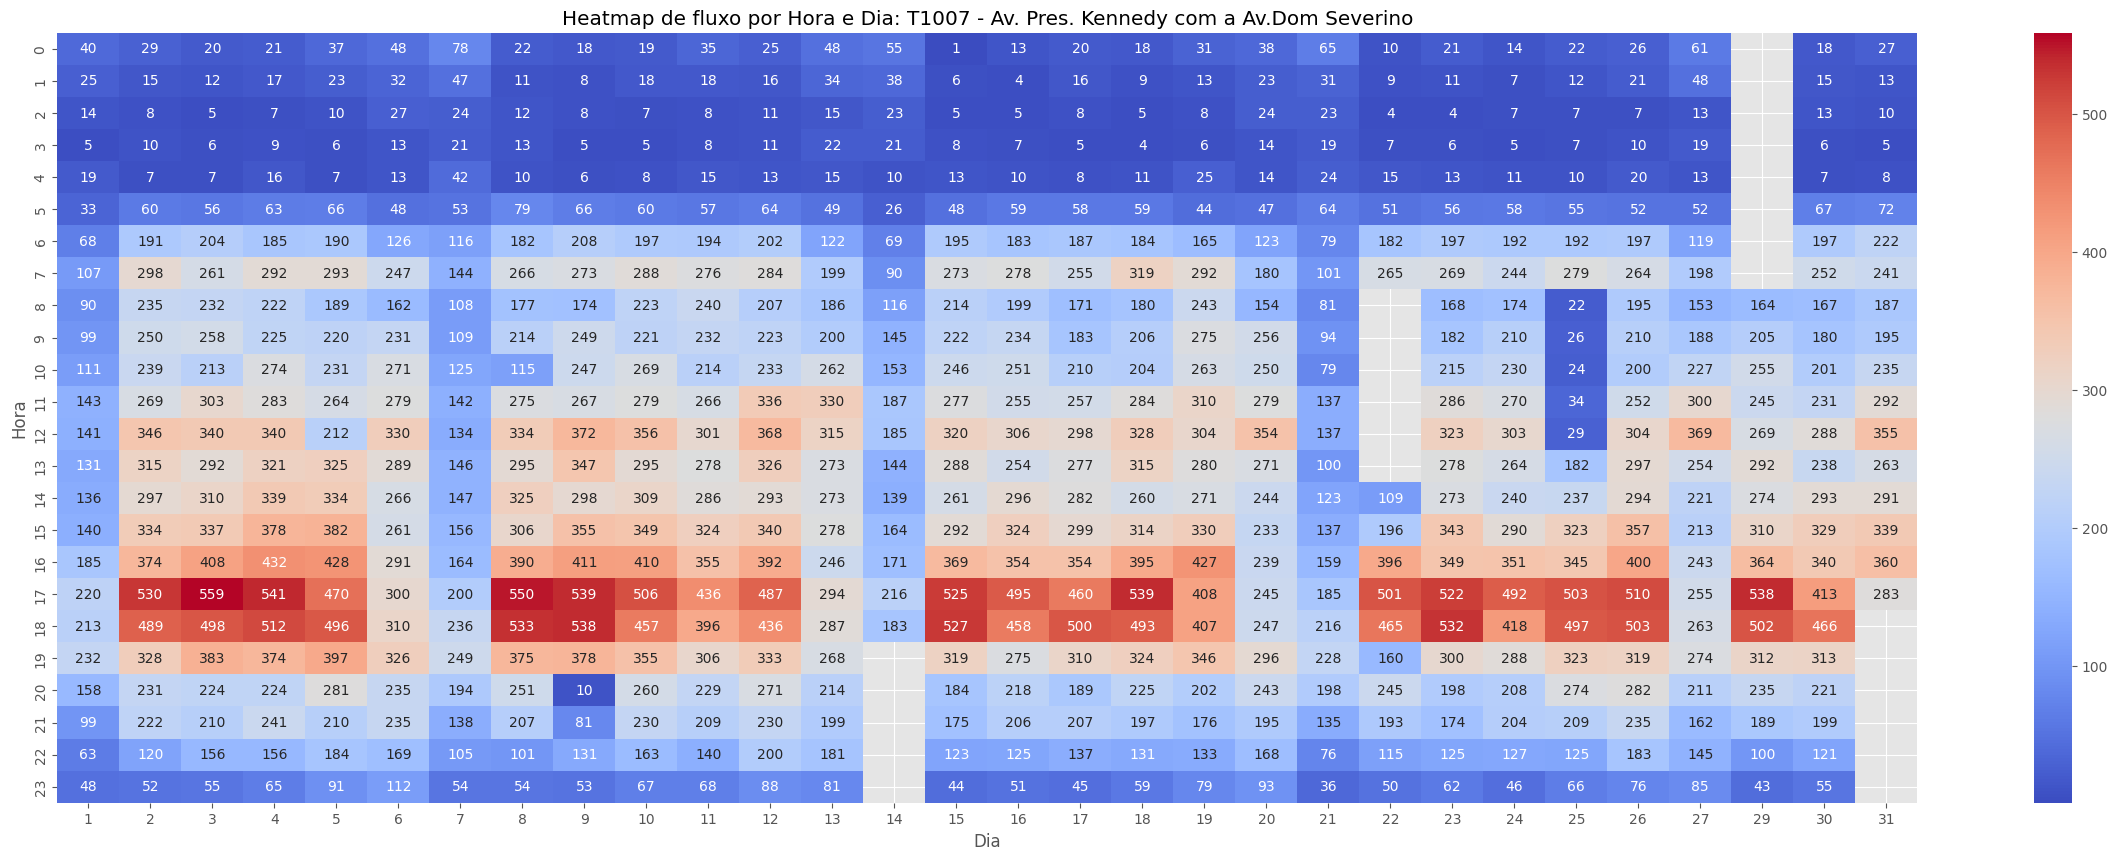

Number of NaN values: 25
No sequence of 24 NaN values found.


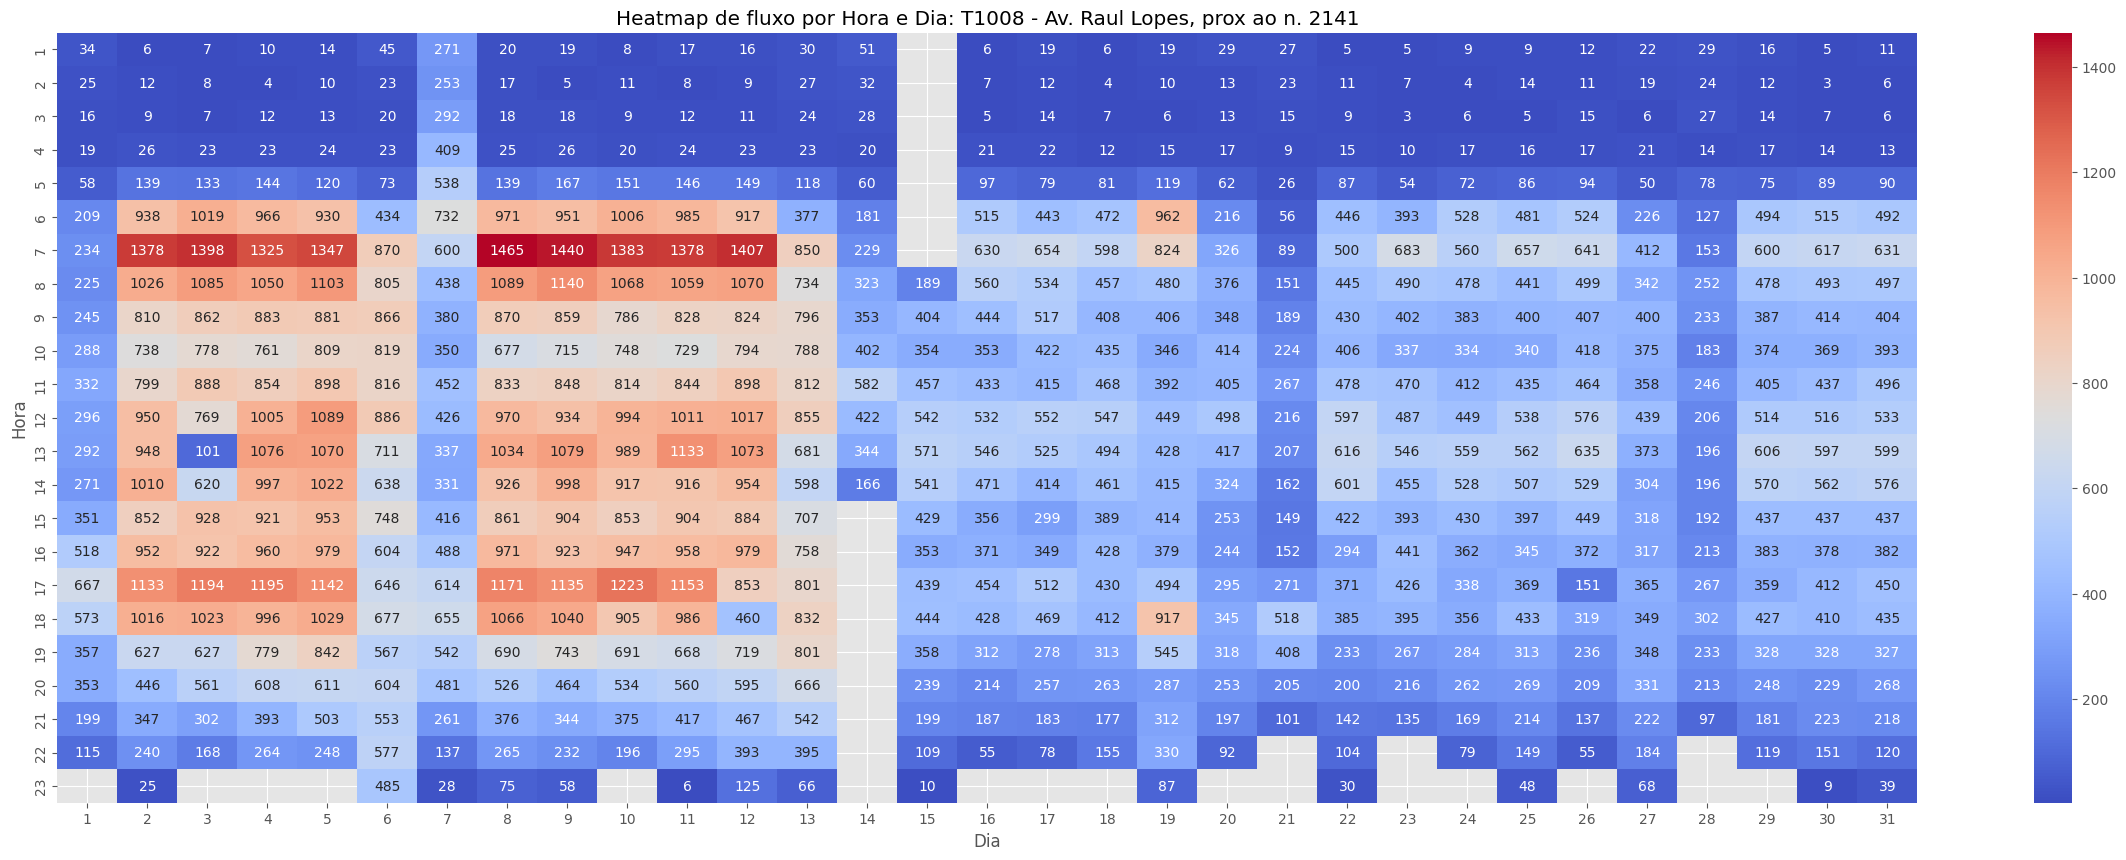

Number of NaN values: 34
No sequence of 24 NaN values found.


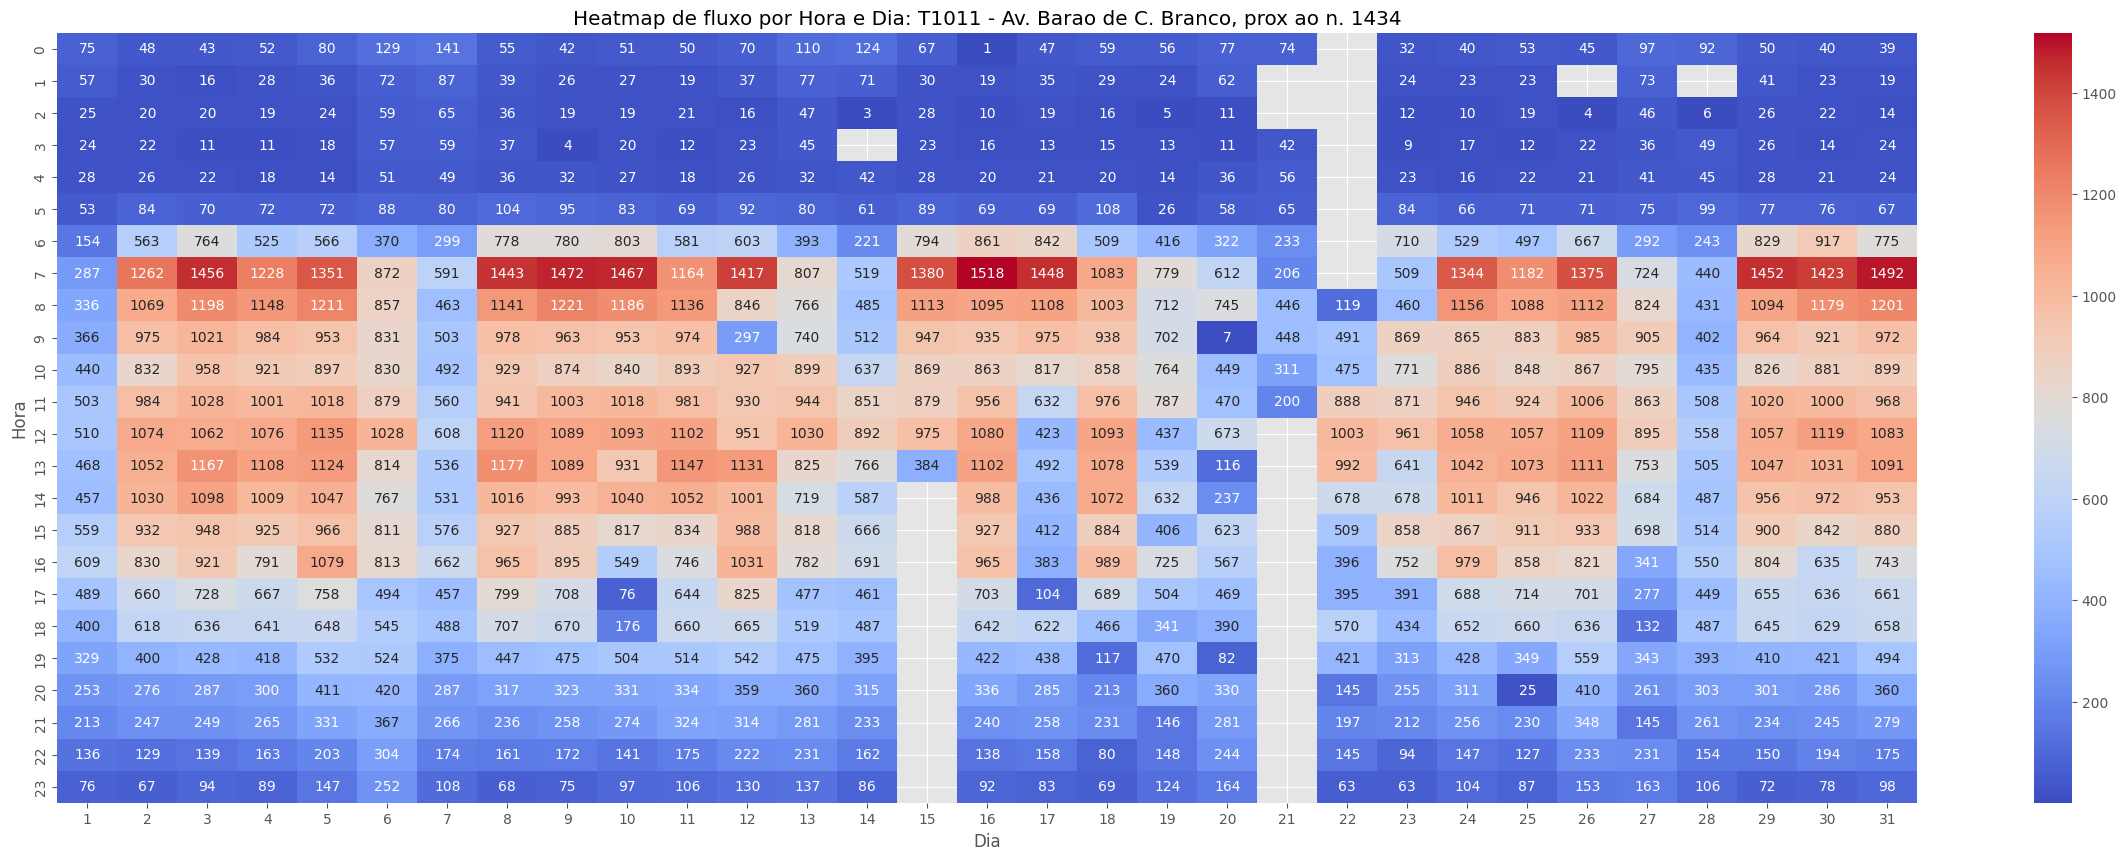

Number of NaN values: 35
No sequence of 24 NaN values found.


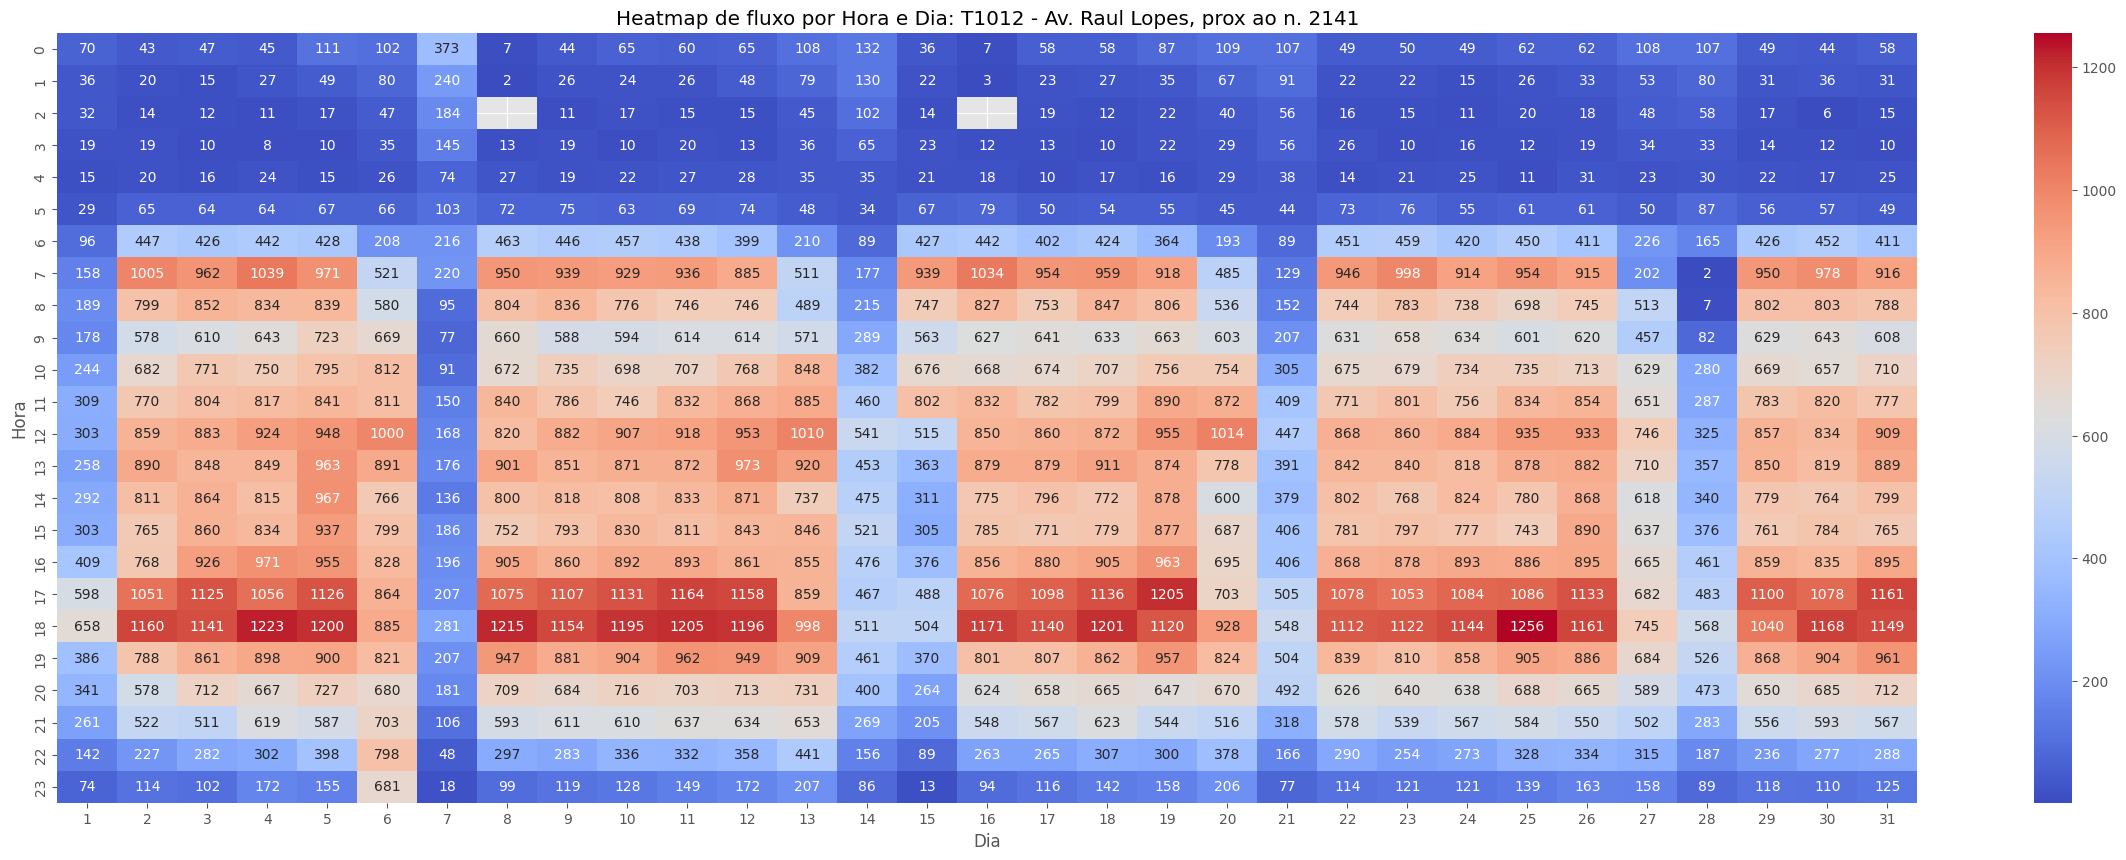

Number of NaN values: 2
No sequence of 24 NaN values found.


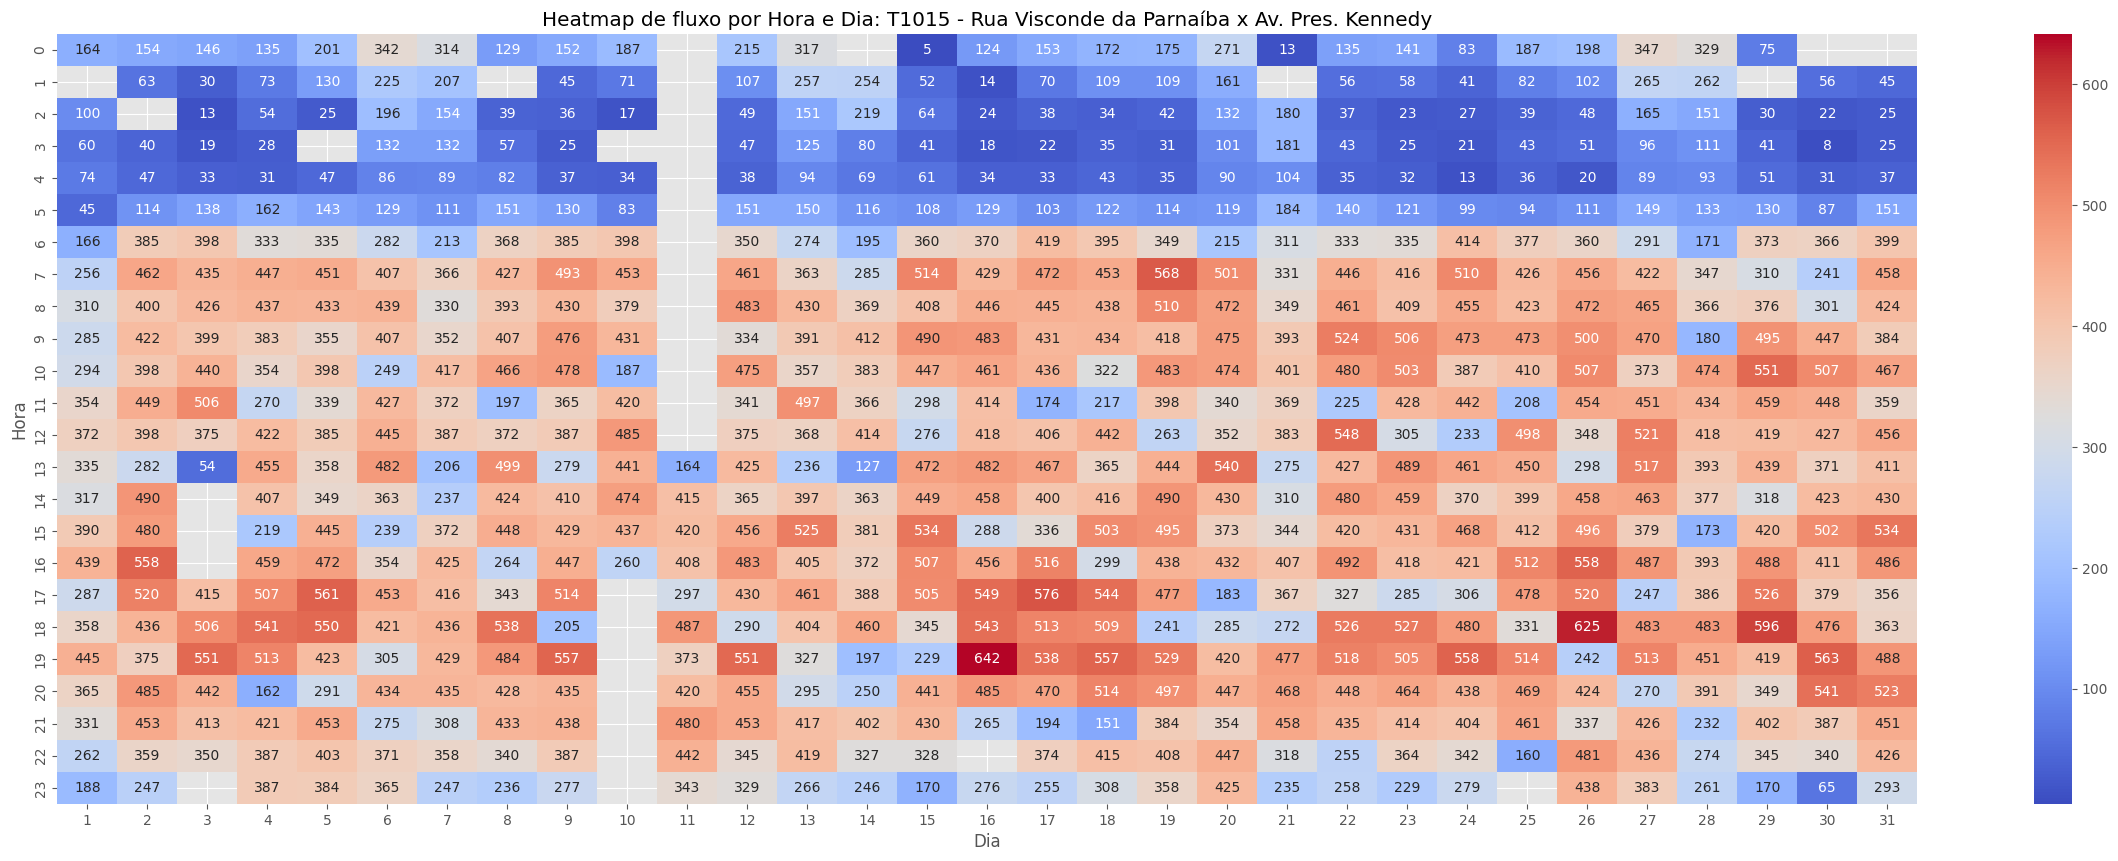

Number of NaN values: 36
No sequence of 24 NaN values found.


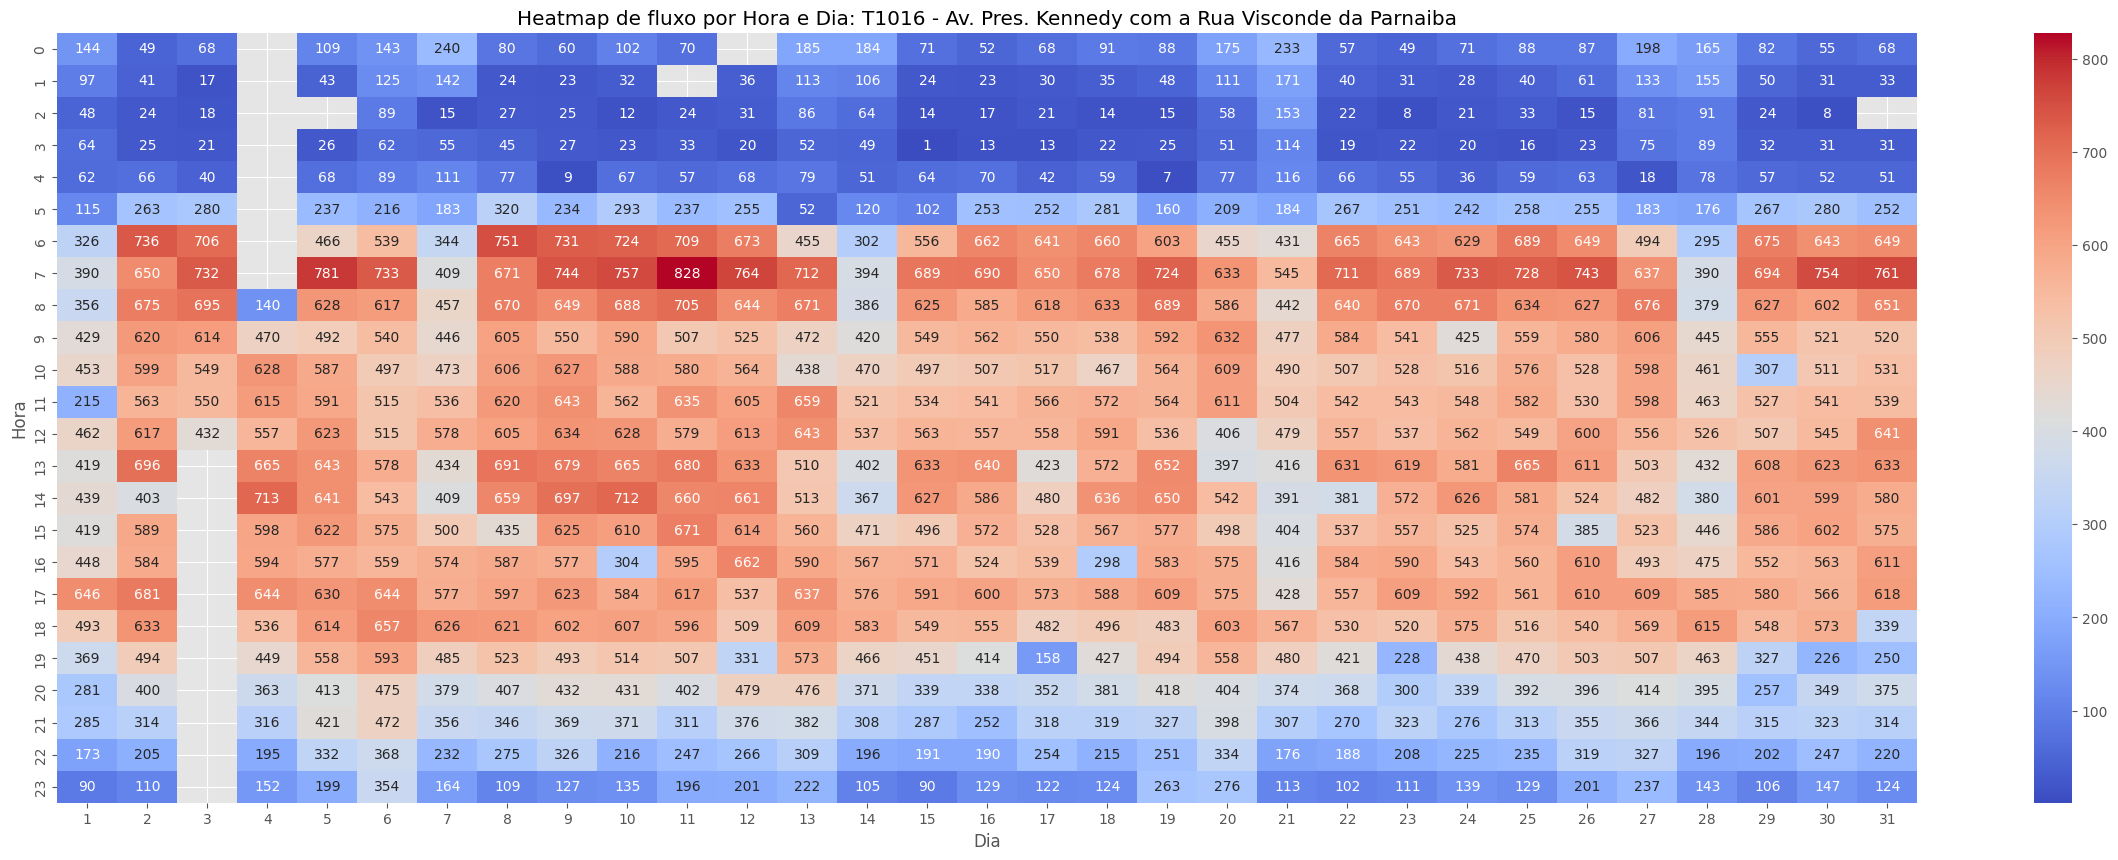

Number of NaN values: 23
No sequence of 24 NaN values found.


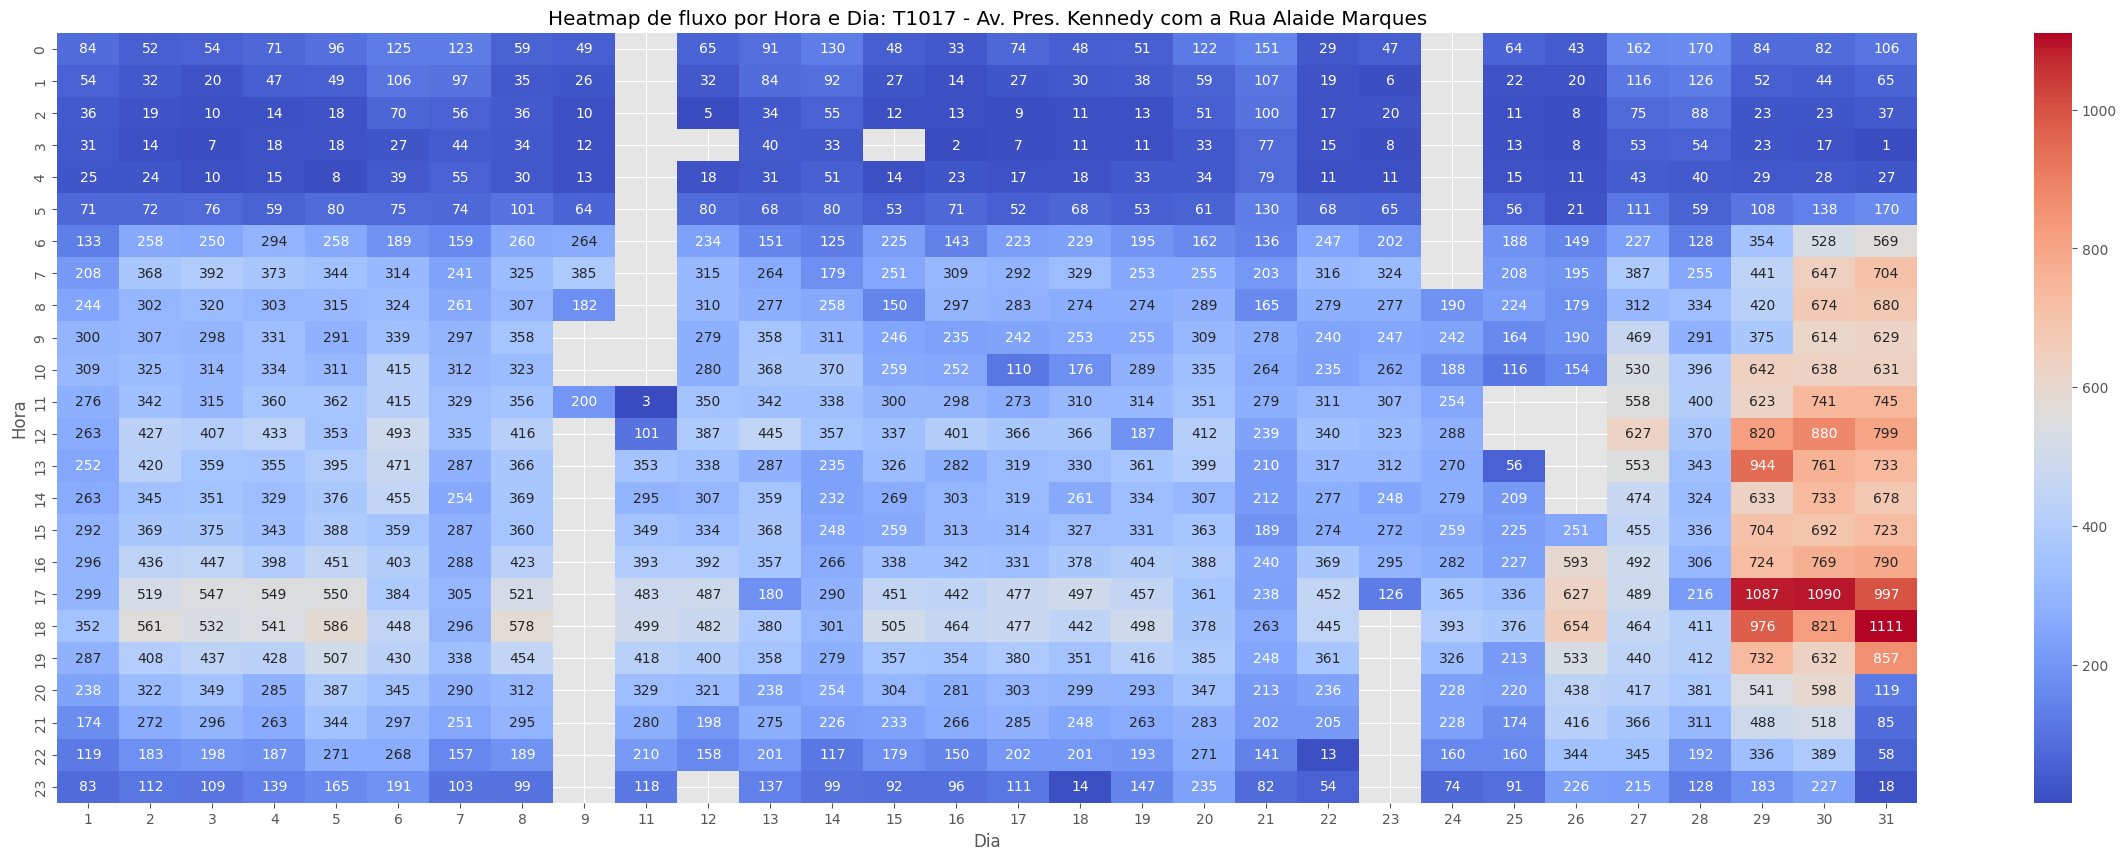

Number of NaN values: 48
No sequence of 24 NaN values found.


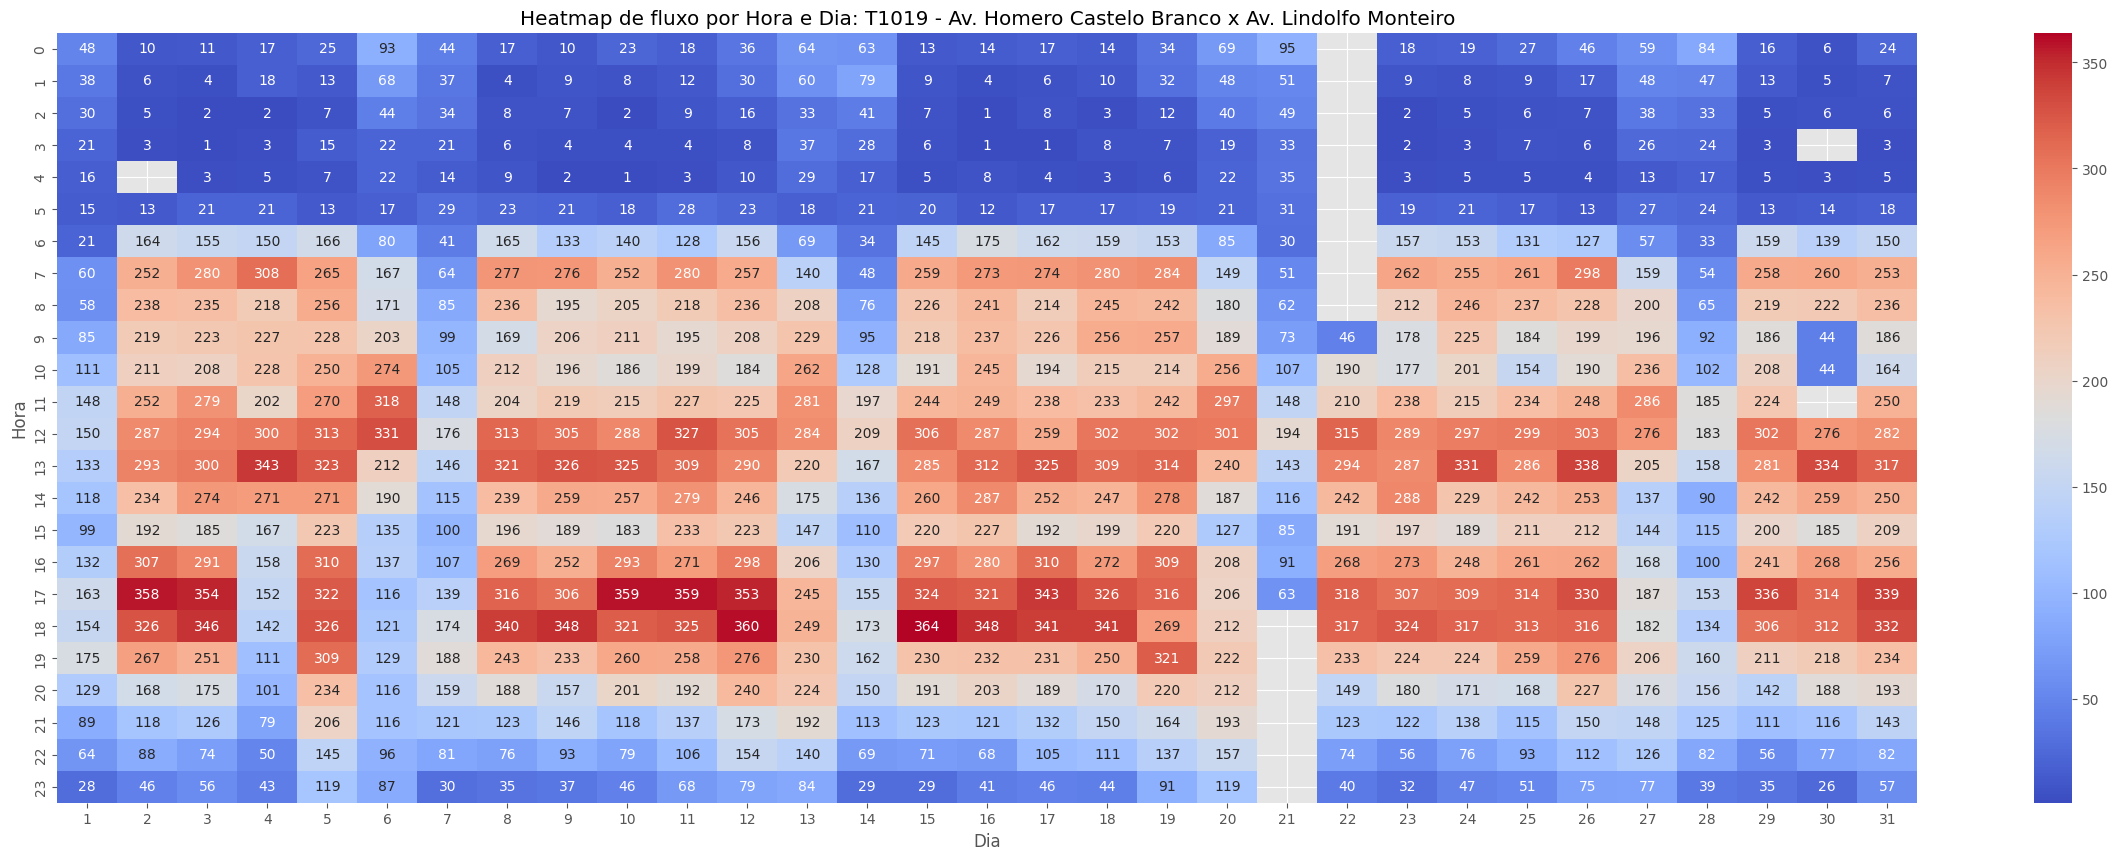

Number of NaN values: 18
No sequence of 24 NaN values found.


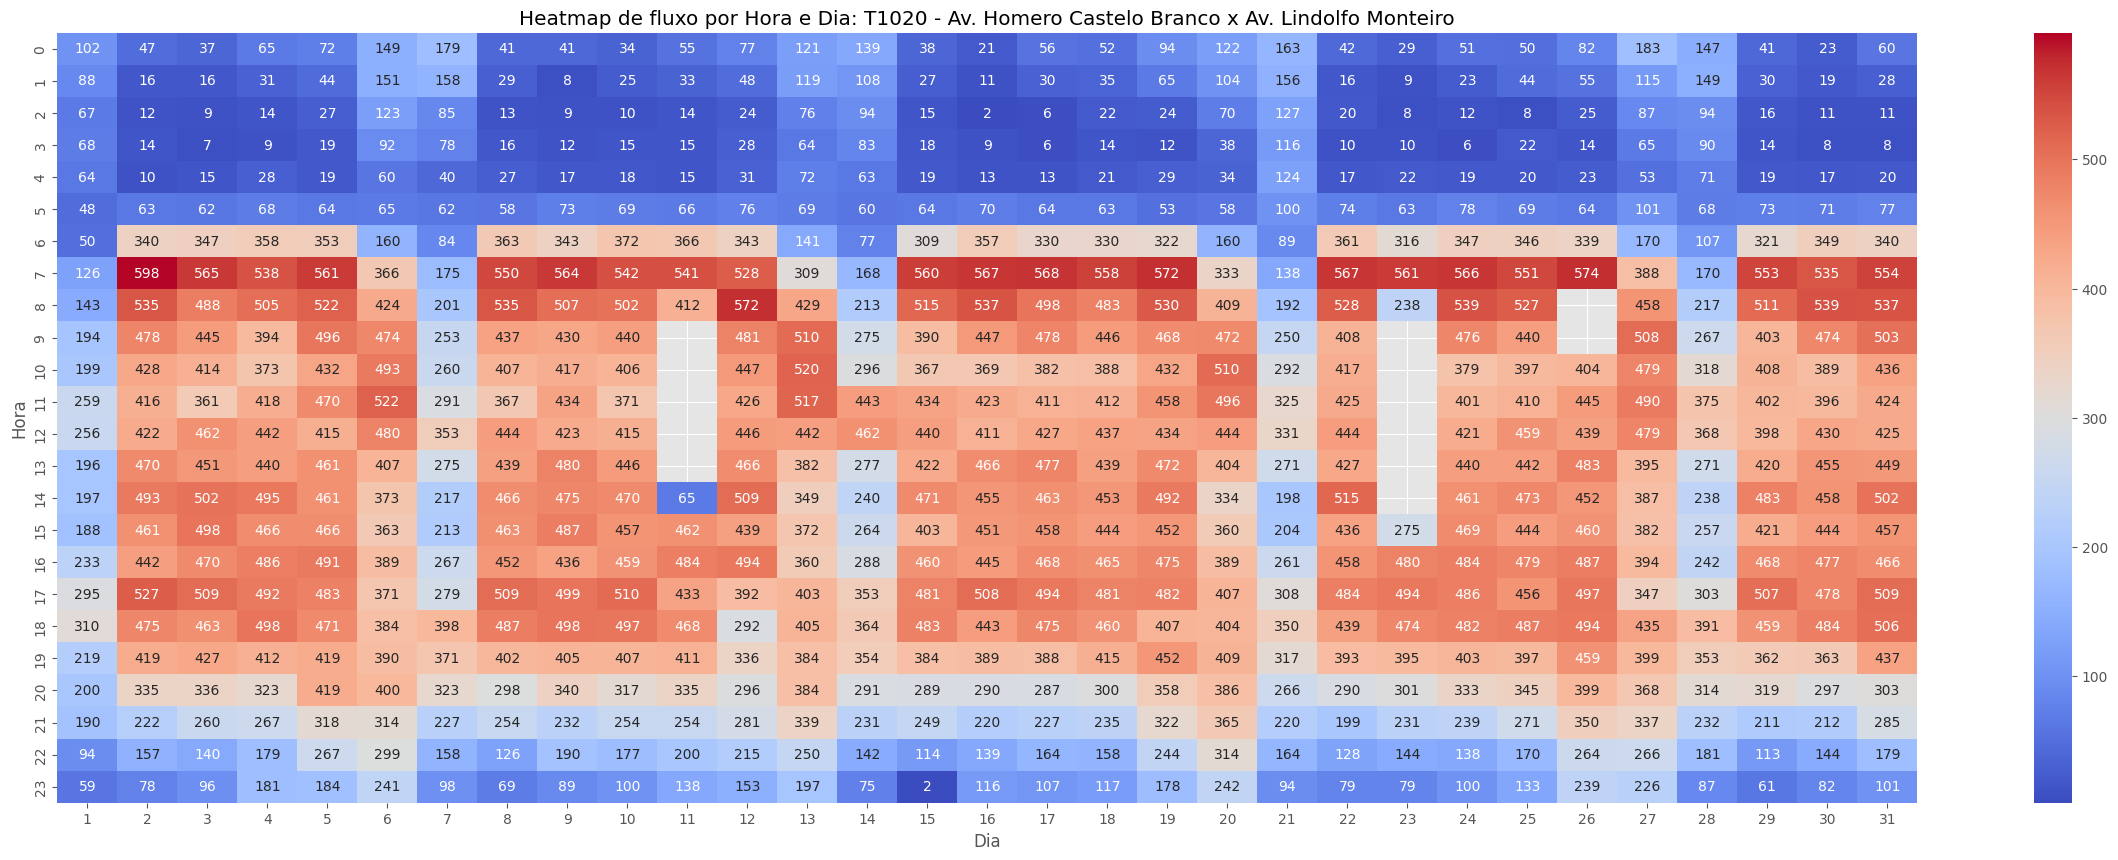

Number of NaN values: 13
No sequence of 24 NaN values found.


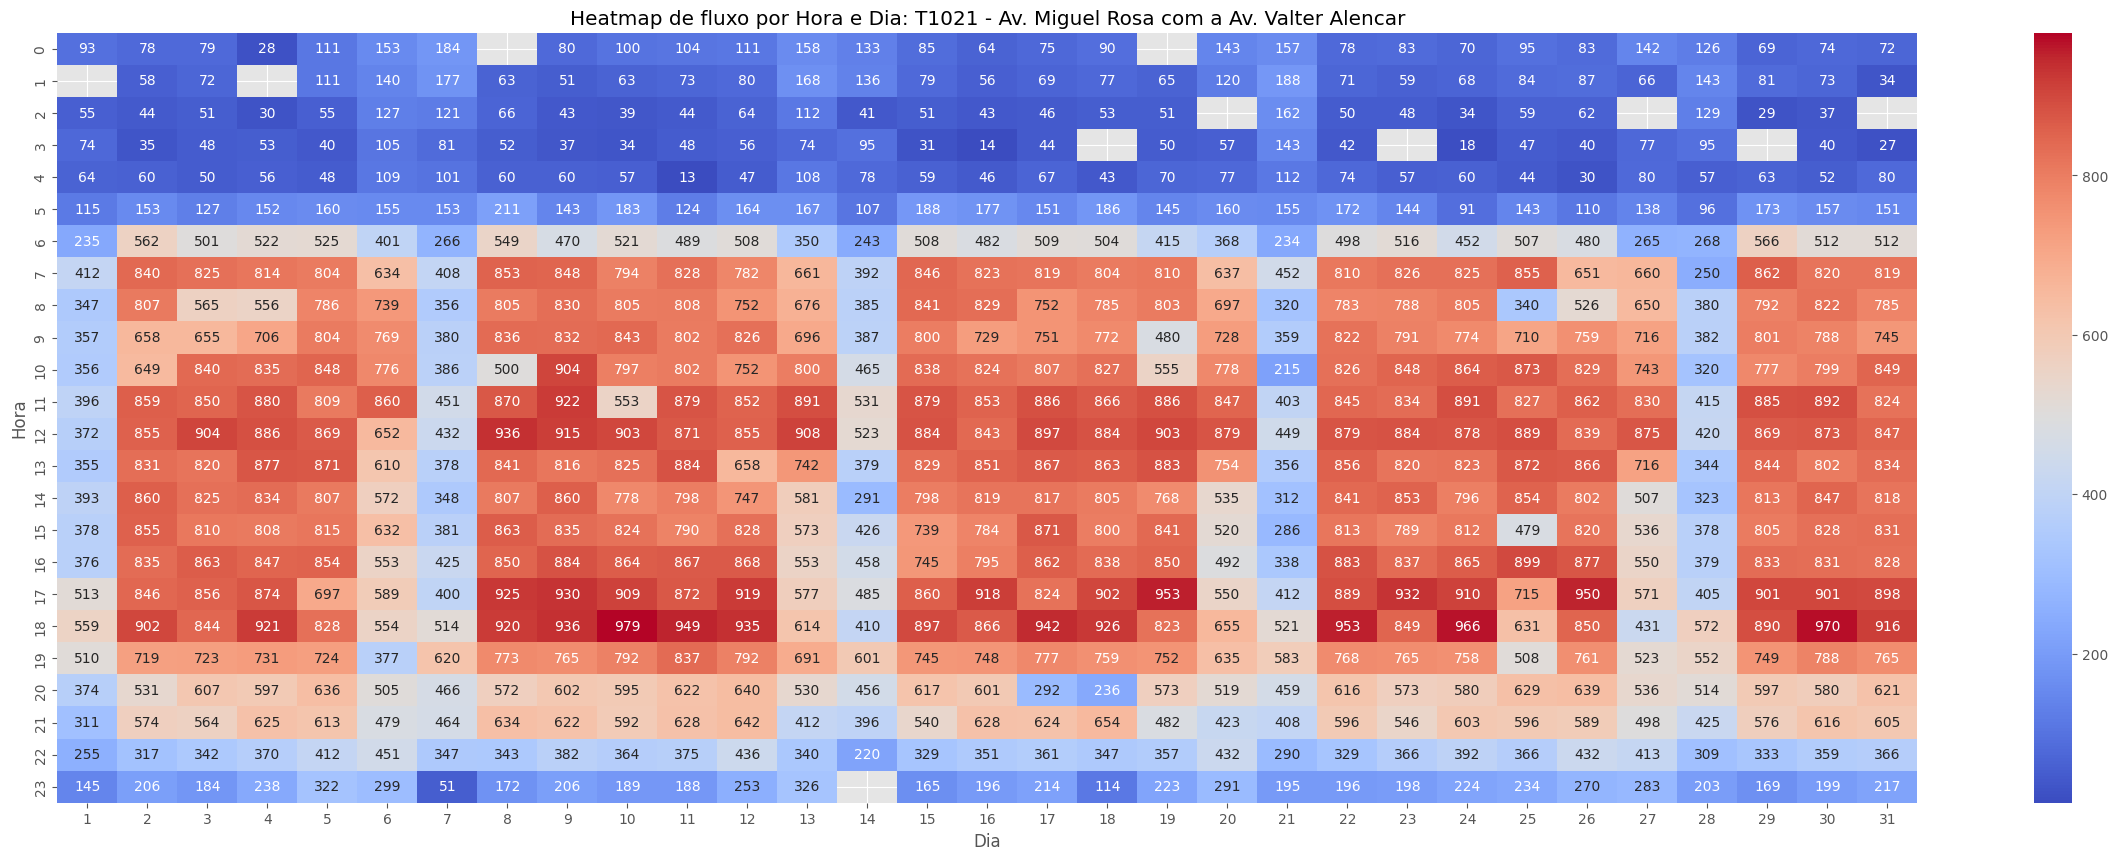

Number of NaN values: 11
No sequence of 24 NaN values found.


In [17]:
adresses = combined_df['Equipamento'].unique()[5:15]  # Slice to get only 10 elements
for adrees in adresses:
    heatmap_equip(adrees)

In [19]:
df  = combined_df.groupby(['dia', 'hora']).size().reset_index(name='count')
df['count'] = df['count'].astype(int)
df = df.pivot_table(index=('hora'), columns= str('dia'), values='count', aggfunc='sum')
fig = px.imshow(df, text_auto=True, aspect="auto", color_continuous_scale='RdBu_r')
fig.show()